In [1]:
import xarray as xr
import numpy as np
from scipy.interpolate import interp1d, griddata
import matplotlib.pyplot as plt
import glob
import gsw
from haversine import haversine
import os
from pathlib import Path

import cartopy.crs as ccrs

# custom functions 
from utils import *

## Introduction to Python for Physical Oceanography

There are a lot of useful python tutorials out there, but few that really focus on the tools and types of workflows that are commonly employed when doing data analysis in physical oceanography. Here we'll go over some of the basic tools and how you'd might use them to load data, make figures, and do scientific analysis. More resources for learning python in general can be found [here] and [here]

### Scientific Computing

In [1]:
import numpy as np

The haversine formula calculates the great-circle distance between two points on a sphere:

$$
a = \sin^2\left(\frac{\Delta\phi}{2}\right) + \cos(\phi_1)\cos(\phi_2)\sin^2\left(\frac{\Delta\lambda}{2}\right)
$$

$$
c = 2 \arcsin\left( \sqrt{a} \right)
$$

$$
d = R \cdot c
$$

where:

- \( $\phi_1, \phi_2$ \) are the latitudes in radians  
- $\Delta\phi = \phi_2 - \phi_1$ is the difference in latitude  
- $\Delta\lambda = \lambda_2 - \lambda_1$ is the difference in longitude  
- $R$ is Earth’s radius (≈ 6367 km)


In [2]:
def haversine_np(coord1, coord2):
    """
    Calculate the great-circle distance between two points 
    on the earth (specified in decimal degrees), given as (lat, lon) tuples.

    Args:
        coord1: tuple (lat1, lon1)
        coord2: tuple (lat2, lon2)

    Returns:
        Distance in kilometers.
    """
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    km = 6367 * c  # Earth's radius in km
    return km

In [3]:
# live code this
# Coordinates: (lat, lon)
accra = (5.6037, -0.1870)          # Accra, Ghana
woods_hole = (41.5265, -70.6737)   # Woods Hole, MA, USA

distance_km = haversine_np(accra, woods_hole)
print(f"Great-circle distance: {distance_km:.2f} km")

Great-circle distance: 7970.24 km


### Loading Data

In physical oceanography, we're often working with large datasets that are georeferenced - arrays of physical variables like temperature and salinity in which each measurement has a latitude and longitude coordinate. Data structured this way is often packaged in "NetCDF" format (file extension ".nc") and can be read by several python packages. One of the most commonly used is **xarray** [link to xarray github and include some of their info about it]

In [4]:
import xarray as xr
import fsspec

# import glob

In [ ]:
# January, April, August (eventually)
cruise = 'April'

# choose data type: 'oxy', 'ctd', 'fls'
data_type = 'ctd'

url = "https://coessing-2025.s3.us-east-1.amazonaws.com/test-data.nc"

# this is because xarray cannot handle streaming from urls directly but fsspec can!
with fsspec.open(url, mode='rb') as f:
    ds = xr.open_dataset(f, engine='h5netcdf')
    print(ds)

# wkdir = f"{os.environ['WINPATH']}/OneDrive - Massachusetts Institute of Technology/mit-whoi/gulf_of_guinea/coessing_2025/EcoCTD_data/{cruise}/"
# data = glob.glob(wkdir + '*' + data_type + '.nc')

# datasets = [xr.open_dataset(f, decode_timedelta=True) for f in data]

# # get optional density contours 
# data_ctd = glob.glob(wkdir + '*' + 'ctd.nc')
# datasets_ctd = [xr.open_dataset(f) for f in data_ctd]

<xarray.Dataset> Size: 520B
Dimensions:      (lat: 5, lon: 10)
Coordinates:
  * lat          (lat) float64 40B -90.0 -45.0 0.0 45.0 90.0
  * lon          (lon) float64 80B 0.0 40.0 80.0 120.0 ... 280.0 320.0 360.0
Data variables:
    temperature  (lat, lon) float64 400B ...


In [ ]:
import json
import xarray as xr
import fsspec

# Hosted JSON manifest
json_url = "https://coessing-2025.s3.amazonaws.com/data_manifest.json"

# Read JSON from S3
with fsspec.open(json_url, mode='r') as f:
    manifest = json.load(f)

# Choose data type and optional density contour flag
data_type = 'ctd'
density_contour = True

# Load main datasets
datasets = []
for url in manifest.get(data_type, []):
    with fsspec.open(url, mode='rb') as f:
        ds = xr.open_dataset(f, engine='h5netcdf')
        datasets.append(ds)

# Load optional CTD datasets
datasets_ctd = []
if density_contour and data_type != 'ctd':
    for url in manifest.get('ctd', []):
        with fsspec.open(url, mode='rb') as f:
            ds = xr.open_dataset(f, engine='h5netcdf')
            datasets_ctd.append(ds)

# Example use
print(f"Loaded {len(datasets)} {data_type.upper()} files")
if datasets_ctd:
    print(f"Loaded {len(datasets_ctd)} CTD files for density contouring")


### Visualizing Data

### Geophysical Data Analysis

In [ ]:
import cartopy.crs as ccrs

### (0) extract coastal coordinates

<Axes: >

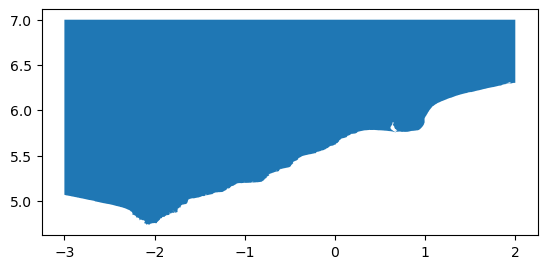

In [15]:
# extract coastline coordinates
region = [-3, 2, 2, 7]

min_area_threshold = 0.01

coast_file = 'GIS_data/GSHHS_f_L1.shp'
coast_gdf = coastline_extraction(region[0], region[1], region[2],
                                 region[3], coast_file)

geom = coast_gdf.head(1).geometry[0]
coast_lon, coast_lat = extract_polygon_coords(geom, min_area_threshold)

coast_gdf.head(1).plot()

### (1) extract transect geographic data

In [16]:
# January, April, August (eventually)
cruise = 'April'

# choose data type: 'oxy', 'ctd', 'fls'
data_type = 'ctd'

wkdir = f"{os.environ['WINPATH']}/OneDrive - Massachusetts Institute of Technology/mit-whoi/gulf_of_guinea/coessing_2025/EcoCTD_data/{cruise}/"
data = glob.glob(wkdir + '*' + data_type + '.nc')

datasets = [xr.open_dataset(f, decode_timedelta=True) for f in data]

# get optional density contours 
data_ctd = glob.glob(wkdir + '*' + 'ctd.nc')
datasets_ctd = [xr.open_dataset(f) for f in data_ctd]

/tmp/ipykernel_406569/2499768648.py:14: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  datasets_ctd = [xr.open_dataset(f) for f in data_ctd]
/tmp/ipykernel_406569/2499768648.py:14: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 va

In [17]:
from scipy.stats import linregress

# extract profile coordinates
coords = [(ds.lat[0].values.item(), ds.lon[0].values.item()) for ds in datasets]

profile_lats, profile_lons = zip(*coords)
profile_lats = np.array(profile_lats)
profile_lons = np.array(profile_lons)

slope, intercept, _, _, _ = linregress(profile_lons, profile_lats)

def transect_line(lon):
    return slope * lon + intercept

coast_lons = np.array(coast_lon)  
coast_lats = np.array(coast_lat)  

transect_lons = np.linspace(min(profile_lons) - 0.1, max(profile_lons) + 0.1, 100)  # Extended range
transect_lats = slope * transect_lons + intercept

In [18]:
for i in range(len(transect_lons) - 1):
    # Get the transect segment
    p1 = (transect_lons[i], transect_lats[i])
    p2 = (transect_lons[i+1], transect_lats[i+1])

    # Loop over each coastline segment
    for j in range(len(coast_lon) - 1):
        # Get the coastline segment
        q1 = (coast_lon[j], coast_lat[j])
        q2 = (coast_lon[j+1], coast_lat[j+1])

        # Check if the transect segment intersects with the coastline segment
        if do_lines_intersect(p1, p2, q1, q2):
            print(f"Intersection found between transect segment {i} and coastline segment {j}")

            transect_p1 = (transect_lons[i], transect_lats[i])
            transect_p2 = (transect_lons[i+1], transect_lats[i+1])
            coast_q1 = (coast_lon[j], coast_lat[j])
            coast_q2 = (coast_lon[j+1], coast_lat[j+1])
            
            intersect_lon, intersect_lat = line_intersection(transect_p1, transect_p2, coast_q1, coast_q2)
            print(f"Intersection at: {(intersect_lon, intersect_lat)}")

Intersection found between transect segment 19 and coastline segment 1452
Intersection at: (np.float64(-0.0735782597617998), np.float64(5.590148973436938))


In [19]:
# compute distance from each profile to the coastline intersection point
original_indices = np.arange(len(profile_lats))

distance = np.array([
    haversine((lat, lon), (intersect_lat, intersect_lon))
    for lat, lon in zip(profile_lats, profile_lons)
])

# sort profiles from inshore (closest to coast) to offshore
sort_idx = np.argsort(distance)
profile_lats = profile_lats[sort_idx]
profile_lons = profile_lons[sort_idx]

flipped = np.all(sort_idx[::-1] == original_indices)


# load bathymetry data
df = xr.open_dataset('GIS_data/gebco_2023_n12.0_s-12.0_w-21.0_e16.0.nc')

df = df.sel(lon = slice(region[0], region[1]), lat=slice(region[2], region[3]))
b_lats = df["lat"].values
b_lons = df["lon"].values
d_depths = df["elevation"].values

b_lons, b_lats = np.meshgrid(b_lons, b_lats)

# Flatten all three
b_lons = b_lons.ravel()
b_lats = b_lats.ravel()
b_depths = d_depths.ravel()
    

    
transect_depths = griddata(
    (b_lons, b_lats), b_depths, (profile_lons, profile_lats), method='nearest'
)

# filter out points off the shelf
depth_changes = np.abs(np.diff(transect_depths))

jump_index = np.where(depth_changes > 150)[0]

if jump_index.size > 0: 
    first_jump = jump_index[0] + 1  # +1 to include the first invalid point
    transect_depths[first_jump:] = np.nan


Text(0.5, 1.0, 'April Sakumono Transect')

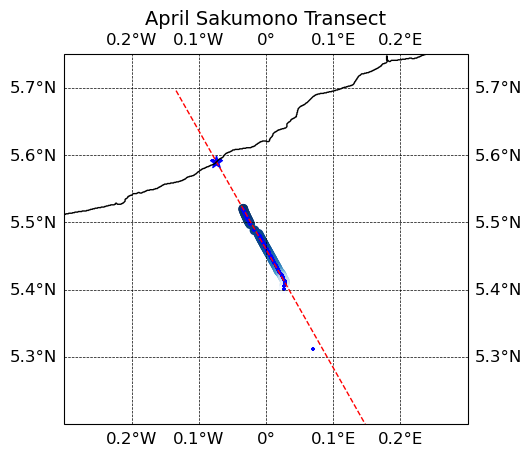

In [20]:
# check
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(color='black', linestyle='dashed', draw_labels=True, linewidth=0.5)
gl.xlabel_style = {'size': 12}  
gl.ylabel_style = {'size': 12}

ax.set_xlim(-0.3, 0.3)
ax.set_ylim(5.2, 5.75)

# include sampled bathy
plt.scatter(profile_lons, profile_lats, c=transect_depths, cmap='Blues')

# include all bathy
# plt.scatter(b_lons, b_lats, s=2)
# plt.scatter(b_lons, b_lats, c=b_depths, cmap='Reds')


# plot the regression line
ax.plot(transect_lons, transect_lats, color='r', linestyle='--', linewidth=1, label='Transect Fit')

# plot the coastline
ax.plot(coast_lons, coast_lats, c='k', linewidth=1)

# plot the profile locations and coastal intersection point
plt.scatter(profile_lons, profile_lats, color='blue', label='Profiles', s=10, marker='+')
plt.scatter(intersect_lon, intersect_lat, color='blue', label='Profiles', s=80, marker='*')

plt.title(f'{cruise} Sakumono Transect', fontsize=14)

# optional: save figure
# filename = f"{cruise}_{transect_name}_transect_map.png"
# plt.savefig(os.path.join(os.getcwd(),'figures', filename), dpi=300, bbox_inches='tight')


In [21]:
# swap the direction of the profiles and data so they always plot from nearshore to offshore
if flipped:
    coords = coords[::-1]
    datasets = datasets[::-1]
    datasets_ctd = datasets_ctd[::-1]
    distance = distance[::-1]

    print("the data in this netcdf is flipped")

In [22]:
# data exceptions
if cruise == 'April':
    # remove the last profile
    coords = coords[:-1]
    datasets = datasets[:-1]
    datasets_ctd = datasets_ctd[:-1]
    distance = distance[:-1]
    transect_depths = -transect_depths[:-1]

In [23]:
# np.save(f"{cruise}_distance.npy", distance)

### (2) plot transects as pcolor 

In [24]:
if data_type=='ctd':
    variables = ["CT", "SA", "rho"]
    colors = ["magma", "viridis", "BuPu"]
elif data_type=='oxy':
    variables = ["O2"]
    colors = ["YlGnBu"]
else:
    variables = ["chl_cal", "bb470_cal"]
    colors = ["YlGn", "viridis"]

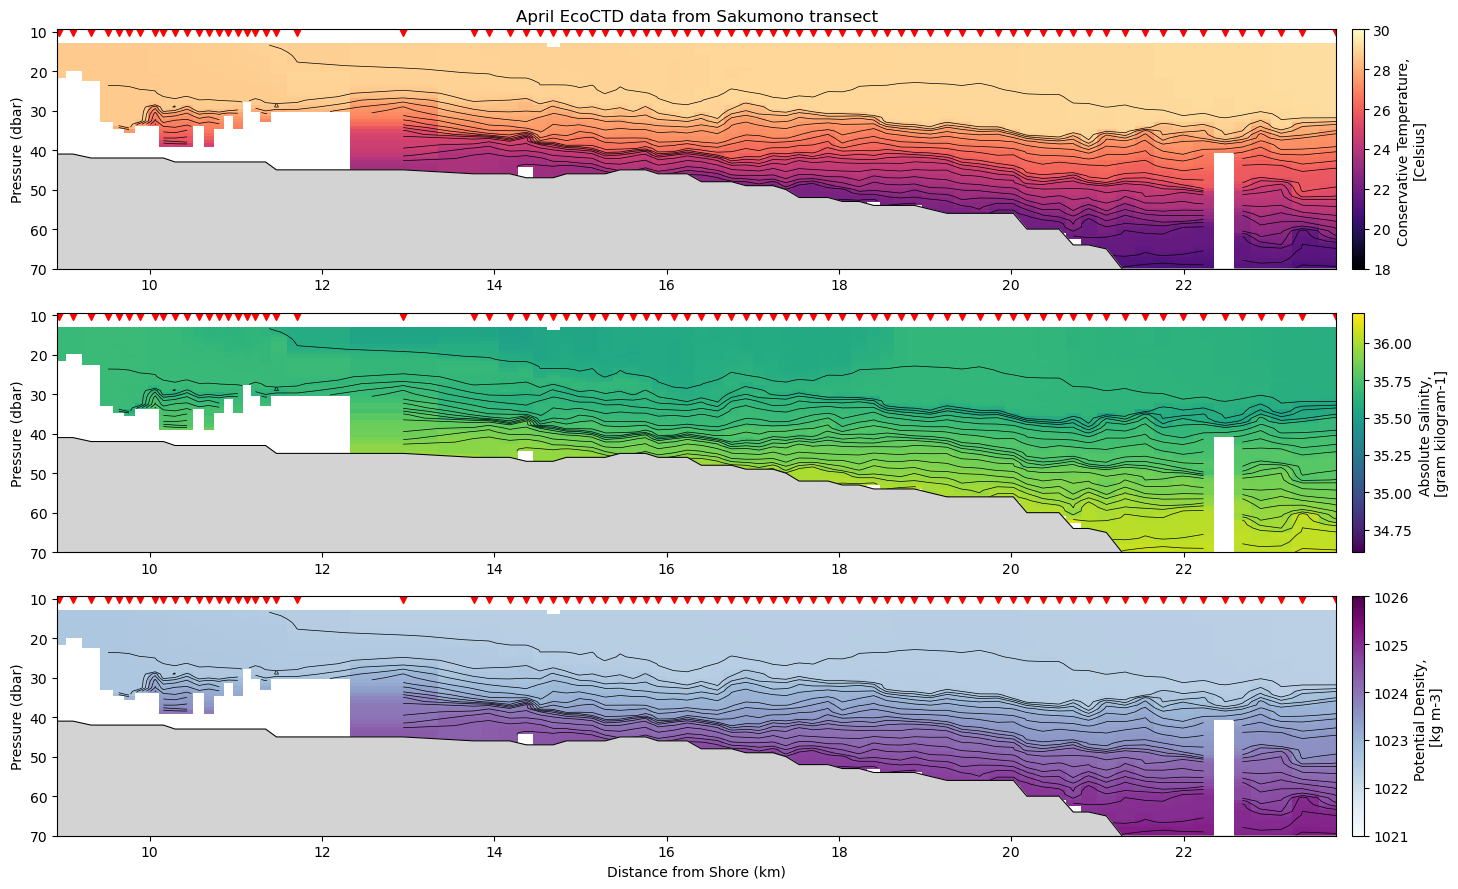

In [25]:
do_interpolate = True
extrapolate = False
ignore_questionable = True
include_topo = True
use_density_contours = True

manual_thresholds = {
    "chl_cal": (0.0, 1.5),
    "bb470_cal": (0.0, 0.002),
    "O2": (100, 230),
    "SA": (34.6, 36.2),
    "rho": (1021, 1026),
    "CT": (18, 30)
}

depth_limit = 70

min_depth = min(ds["P"].min().values for ds in datasets)  # Shallowest recorded depth
max_depth = min(depth_limit, max(ds["P"].max().values for ds in datasets))  # Max depth (up to 40m)

depth_grid = np.linspace(min_depth, max_depth, depth_limit)

# compute rho_profiles globally from datasets_ctd
if  use_density_contours:
    
    all_rho_profiles = []

    for ds in datasets_ctd:
        P = ds["P"].values
        rho = ds["rho"].values

        min_rho, max_rho = manual_thresholds['rho']
        manual_mask_rho = (rho >= min_rho) & (rho <= max_rho)

        valid_mask = ~np.isnan(P) & ~np.isnan(rho) & manual_mask_rho
        P = P[valid_mask]
        rho = rho[valid_mask]

        if len(P) > 1:
            interp_func_rho = interp1d(P, rho, kind='linear', bounds_error=False)
            rho_interp = interp_func_rho(depth_grid)
            all_rho_profiles.append(rho_interp)

    # stack into a 2D array: [depth, profile index]
    all_rho_profiles = np.stack(all_rho_profiles, axis=1)

    rho_min = np.nanmin(all_rho_profiles)
    rho_max = np.nanmax(all_rho_profiles)
    rho_levels = np.linspace(rho_min, rho_max, 25)                                                                                                          


fig, axs = plt.subplots(len(variables), 1, figsize=(16, 3 * len(variables)))

if len(variables) == 1:
    axs = [axs]

for idx, var in enumerate(variables):  # Loop over variables
    
    profiles = np.full((depth_limit, len(datasets)), np.nan)

    ax = axs[idx]

    if use_density_contours:
        rho_profiles = np.full((depth_limit, len(datasets)), np.nan)

    for i, ds in enumerate(datasets):

        P = ds["P"].values  

        if use_density_contours:
            ds_ctd = datasets_ctd[i]
            rho = ds_ctd["rho"].values
            
        if var in ds:
            V = ds[var].values 

            if var == 'O2':
                V = V*1000

            if var == 'rho':
                # convert to potential density
                SA = ds["SA"].values
                CT = ds["CT"].values
                V = gsw.pot_rho_t_exact(SA, CT, P, 0)

            # qc filtering
            qc_mask = np.ones_like(V, dtype=bool)

            qc_var = f"{var}_qc"
            if qc_var in ds:
                QC = ds[qc_var].values

                # always exclude -1 (bad), optionally exclude 0 (questionable)
                if ignore_questionable:
                    qc_mask = QC == 1
                else:
                    qc_mask = (QC == 1) | (QC == 0)

            # optional manual filtering
            manual_mask = np.ones_like(V, dtype=bool)
            if var in manual_thresholds:
                min_val, max_val = manual_thresholds[var]
                manual_mask = (V >= min_val) & (V <= max_val)

            valid_mask = ~np.isnan(P) & ~np.isnan(V) & qc_mask & manual_mask
 
            P = P[valid_mask]  
            V = V[valid_mask] 

            if use_density_contours: 
                rho = rho[valid_mask] 

            if do_interpolate:
                if len(P) > 1:  # only interpolate if there are enough points
                    interp_func = interp1d(P, V, kind='linear', bounds_error=False)
                    interp_values = interp_func(depth_grid)
    
                    profiles[:, i] = interp_values

                    if use_density_contours:
                        interp_func_rho = interp1d(P, rho, kind='linear', bounds_error=False)
                        rho_interp = interp_func_rho(depth_grid)
                        rho_profiles[:, i] = rho_interp
            else:
                for j, depth in enumerate(P):
                    k = np.argmin(np.abs(depth_grid - depth))  # Find closest depth
                    profiles[k, i] = V[j]
                    if use_density_contours: 
                        rho_profiles[k,i] = rho[j] 
    
    nan_mask = np.isnan(profiles)

    if extrapolate:    
        exclude_profiles = [] #np.arange(1, 22)  # profiles to skip extrapolation 
        
        for k in range(depth_limit):  # loop over depth rows
            row = profiles[k, :]
            row_rho = rho_profiles[k, :]

            # mask out excluded profiles for extrapolation
            row = row.copy()
            row_rho = row_rho.copy()
            row[exclude_profiles] = np.nan
            row_rho[exclude_profiles] = np.nan
            
            if np.any(np.isfinite(row)) and np.any(~np.isfinite(row)):
                x = np.arange(len(row))
                mask = np.isfinite(row)
                try:
                    interp_row = interp1d(x[mask], row[mask], kind='linear', bounds_error=False, fill_value='extrapolate')
                    new_vals = interp_row(x)
                    # apply new values *only* to non-excluded profiles
                    for j in range(len(row)):
                        if j not in exclude_profiles:
                            profiles[k, j] = new_vals[j]

                    interp_rho = interp1d(x[mask], row_rho[mask], kind='linear', bounds_error=False, fill_value='extrapolate')
                    new_rho = interp_rho(x)
                    for j in range(len(row)):
                        if j not in exclude_profiles:
                            rho_profiles[k, j] = new_rho[j]
                except Exception as e:
                    pass


    extrapolated_mask = nan_mask & np.isfinite(profiles)
    
    X, Y = np.meshgrid(distance, depth_grid)

    if var in manual_thresholds:
        vmin, vmax = manual_thresholds[var]
    else:
        vmin, vmax = np.nanmin(profiles), np.nanmax(profiles)
    
    mesh = ax.pcolormesh(X, Y, profiles, shading='auto', cmap=colors[idx], 
                         vmin=vmin, vmax=vmax, zorder=1) # or shading='auto' 'gouraud
    
    filled = rho_profiles if use_density_contours else profiles
    filled = fill_nan_2d(filled)
    filled[np.isnan(profiles)] = np.nan  # optional: skip this step
    contour_data = np.ma.masked_invalid(filled)
    contours = ax.contour(X, Y, contour_data, colors='black', linewidths=0.5, levels=rho_levels, zorder=2)

    # add hatching for extrapolated regions
    if extrapolate:
        hatch_mask = np.ma.masked_where(~extrapolated_mask, extrapolated_mask)
        ax.contourf(X, Y, hatch_mask, levels=[0.5, 1.5], hatches=['////'], colors='none', zorder=3)

    
    cbar = plt.colorbar(mesh, ax=ax, pad=0.01) 
    if data_type=='oxy':
        cbar.set_label(f"Oxygen Concentration, \n[mmol m-3]")
    elif var=='rho':
        cbar.set_label(f"Potential Density, \n[kg m-3]")
    else:
        cbar.set_label(f"{ds[var].long_name}, \n[{ds[var].units}]") 
    
    ax.scatter(distance, [min_depth] * len(distance), color='red', marker='v', s=50, label="Profile Locations", zorder=5)

    if idx==len(variables)-1: ax.set_xlabel("Distance from Shore (km)")
    ax.set_ylabel("Pressure (dbar)") #"Pressure (dbar)"; "Depth (m)"
    ax.invert_yaxis()  
    if idx==0: ax.set_title(f"{cruise} EcoCTD data from Sakumono transect")
    ax.set_xlim(distance[0], distance[-1])

    if include_topo:
        if transect_depths[0] < 0:
            transect_depths = -transect_depths

        ax.plot(distance, transect_depths, color='k', linewidth=0.75, label='Topography', zorder=4)

        distance = np.array(distance)
        transect_depths = np.array(transect_depths)
    
        mask = ~np.isnan(transect_depths)
        ax.fill_between(
            distance[mask],
            transect_depths[mask],
            y2=depth_grid[-1],
            color='lightgray',
            alpha=1,
            zorder=3,
        )

    ax.set_ylim(depth_limit,min_depth-0.5)

    for spine in ax.spines.values():
        spine.set_zorder(100)
    
    ax.tick_params(zorder=100)

plt.tight_layout()
plt.show()


In [ ]:
filename = f"{cruise}_Sakumono_{data_type}_{depth_limit}m.png"
fig.savefig(os.path.join(os.getcwd(),'figures', filename))

### (3) Make T-S Diagram of all profiles

In [26]:
def T_S_diagram(cruise, color, ax):
    # make grid for potential density contours
    sas = np.linspace(34, 37, 100)  # salinity range 
    cts = np.linspace(10, 38, 100)  # temperature range 
    sigma_grid = np.array([[gsw.sigma0(sa, ct) for sa in sas] for ct in cts])
    
    levels = np.linspace(15, 30, 25)
    CS = ax.contour(sas, cts, sigma_grid, levels=levels, colors='black', linewidths=0.5)

    # Label iso-lines
    x_vals = np.linspace(34.25, 36.25, 5)  
    y_intercepts = [40, 30, 20]  
    label_positions = [
        (x, -5 * (x - 34) + b)  
        for b in y_intercepts
        for x in x_vals
        if 12 <= -5 * (x - 34) + b <= 32
    ]
    ax.clabel(CS, inline=True, fontsize=8, fmt="%.1f", manual=label_positions)  

    # Plot data from each transect and assign a label to the first one only
    labeled = False
    
    wkdir = f"{os.environ['WINPATH']}/OneDrive - Massachusetts Institute of Technology/mit-whoi/gulf_of_guinea/coessing_2025/EcoCTD_data/{cruise}/"
    ctd = glob.glob(wkdir + '*ctd.nc')
    datasets = [xr.open_dataset(f, decode_timedelta=True) for f in ctd]

    for ds in datasets:
        p = ds["P"].values
        t = ds["T"].values
        sa = ds["SA"].values
        pt = gsw.pt_from_t(sa, t, p, 0)
        
        if not labeled:
            ax.scatter(sa, pt, s=1.5, color=color, label=f'{cruise}') 
            labeled = True
        else:
            ax.scatter(sa, pt, s=1.5, color=color)


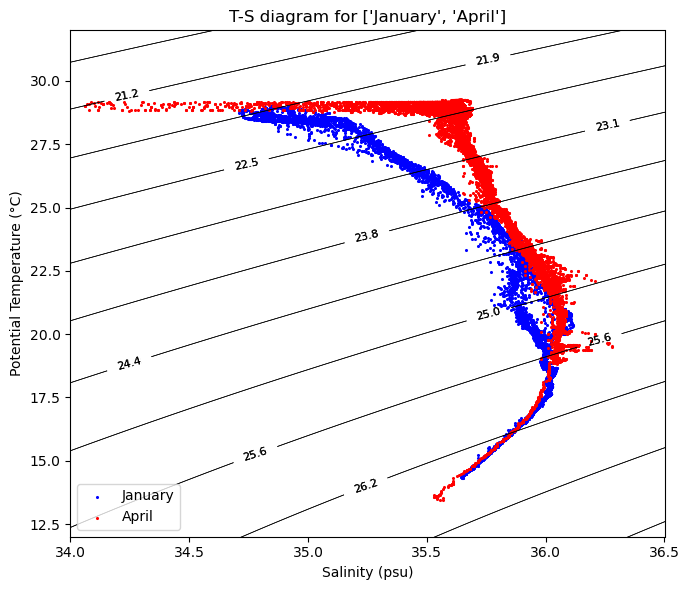

In [27]:
cruises = ['January','April'] # 'August'] 
colors = ['blue', 'red', 'purple']

fig, ax = plt.subplots(figsize=(7, 6))

for i, cruise in enumerate(cruises):
    path = Path(f"{os.environ['WINPATH']}/OneDrive - Massachusetts Institute of Technology/mit-whoi/gulf_of_guinea/coessing_2025/EcoCTD_data/{cruise}/")
    
    T_S_diagram(cruise, colors[i], ax)

# Final labeling and display
ax.set_xlabel("Salinity (psu)")
ax.set_ylabel("Potential Temperature (°C)")
ax.set_title(f"T-S diagram for {[cruise for cruise in cruises]}")
ax.set_xlim([34, 36.5])
ax.set_ylim([12, 32])
ax.legend(loc='lower left', fontsize=10)

plt.tight_layout()
plt.show()


In [106]:
filename = "T_S_diagram.png"
fig.savefig(os.path.join(os.getcwd(),'figures', filename))

### (4) Calculate N^2 and contribution from S and T

(0.0, 0.01)

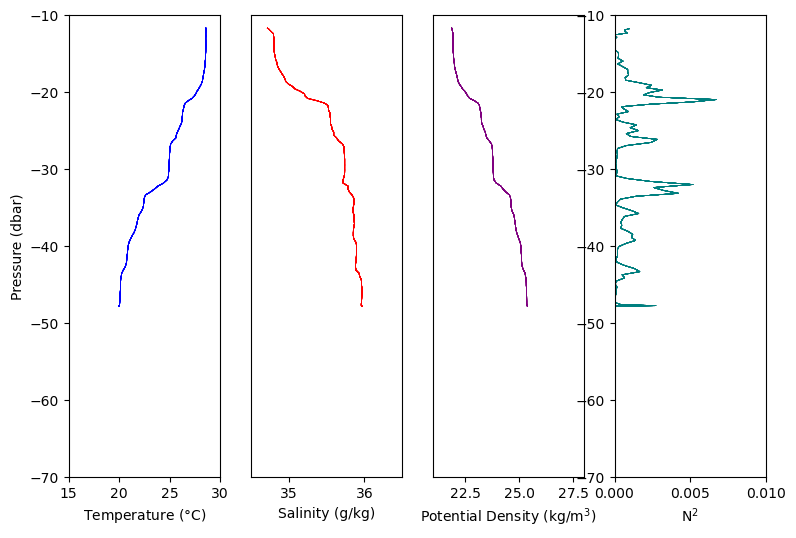

In [ ]:
max_depth = 70 

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(9,6))

for ds in datasets:
    p = ds["P"].values
    ct = ds["CT"].values
    sa = ds["SA"].values
    
    p = interpolate_nans(p, np.arange(len(p)))
    ct = interpolate_nans(ct, np.arange(len(ct)))
    sa = interpolate_nans(sa, np.arange(len(sa)))
    
    sigma = gsw.density.sigma0(sa, ct)
    
    deltaT = np.diff(ct)
    deltaS = np.diff(sa)
    deltaSigma = np.diff(sigma)
    # N2 = deltaSigma * (g/rho)

    N2, _ = gsw.Nsquared(sa, ct, p)
    
    # # calculate alpha and beta
    # alpha = gsw.density.alpha(sa, ct, p)
    # beta = gsw.density.beta(sa, ct, p)
    
    # # interpolate alpha and beta on p_mid
    p_mid = (p[:-1] + p[1:]) / 2
    # alpha_mid = np.interp(p_mid, p, alpha)
    # beta_mid = np.interp(p_mid, p, beta)
    
    # a = alpha_mid*deltaT
    # b = beta_mid*deltaS
    
    # deltarho = (a + b) * -1000
    
    # temp_frac = np.divide(-a * 1000, deltaSigma, where=deltaSigma != 0)
    # sal_frac = np.divide(b * 1000, deltaSigma, where=deltaSigma != 0)
    
    # plot
    ax1.plot(ct, -p, 'b', linewidth=0.5, alpha=0.5)
    
    ax2.plot(sa, -p, c='r', linewidth=0.5, alpha=0.5)
    
    ax3.plot(sigma, -p, c='purple', linewidth=0.5, alpha=0.5)

    ax4.plot(N2, -p_mid, c='teal', linewidth=0.5, alpha=0.5)
    #ax4.plot(temp_frac, -p_mid, 'b', linewidth=0.5, alpha=0.5)
    #ax4.plot(sal_frac, -p_mid[10:], 'r')


ax1.set_ylabel('Pressure (dbar)')
ax1.set_xlabel(r'Temperature ($\degree$C)')
ax1.set_ylim(-max_depth, -10)
ax1.set_xlim(15, 30)

ax2.set_xlabel('Salinity (g/kg)')
ax2.set_yticks([])
ax2.set_ylim(-max_depth, -10)
ax2.set_xlim(34.5, 36.5)

ax3.set_xlabel('Potential Density (kg/m$^3$)')
ax3.set_yticks([])
ax3.set_ylim(-max_depth, -10)
ax3.set_xlim(21, 28)

ax4.set_xlabel('N$^2$')
ax4.set_ylim(-max_depth, -10)
ax4.set_xlim(0, 0.01)

# ax4.set_xlabel(r'Percent Contribution (%)')
# ax4.set_yticks([])
# plt.axvline(x=1, color='k', linestyle='--', linewidth=0.5)
# plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
# ax4.axvspan(1, 2, color='lightgrey', alpha=0.5)
# ax4.axvspan(-1, 0, color='lightgrey', alpha=0.5)
# ax4.set_xlim(-50, 80)
# ax4.set_ylim(-max_depth, -10)

### (5) plot mean profiles of physical variables 

In [28]:
# 'January', 'April', 'August'
cruise = 'April'

data_type = 'ctd'

wkdir = f"{os.environ['WINPATH']}/OneDrive - Massachusetts Institute of Technology/mit-whoi/gulf_of_guinea/coessing_2025/EcoCTD_data/{cruise}/"
data = glob.glob(wkdir + '*' + data_type + '.nc')

datasets = [xr.open_dataset(f, decode_timedelta=True) for f in data]

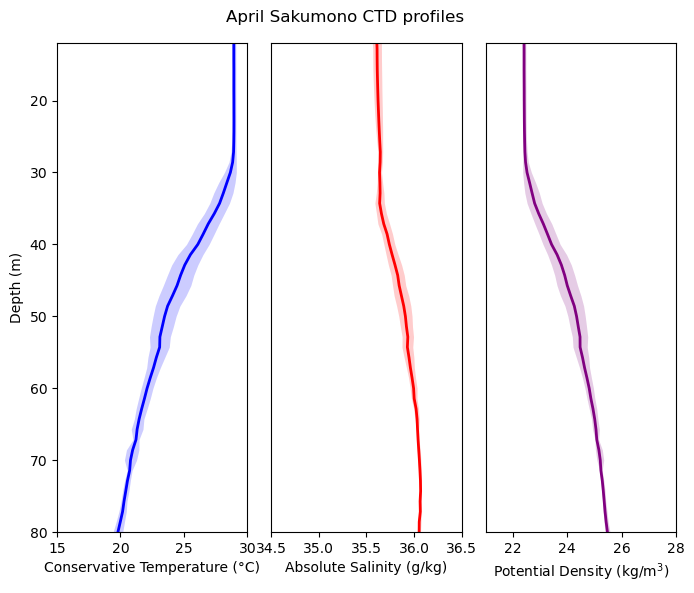

In [29]:
max_depth = 80
depth_grid = np.linspace(10, max_depth, 50)  # Define a common depth grid

# Initialize arrays to store interpolated values
CT_interp = np.full((len(datasets), len(depth_grid)), np.nan)
SA_interp = np.full((len(datasets), len(depth_grid)), np.nan)
sigma_interp = np.full((len(datasets), len(depth_grid)), np.nan)

# Interpolate each profile onto the common depth grid
for i, ds in enumerate(datasets):
    p = ds["P"].values
    ct = ds["CT"].values
    sa = ds["SA"].values
    
    p = interpolate_nans(p, np.arange(len(p)))
    ct = interpolate_nans(ct, np.arange(len(ct)))
    sa = interpolate_nans(sa, np.arange(len(sa)))
    
    # Interpolate to the common depth grid
    CT_interp[i, :] = np.interp(depth_grid, p, ct, left=np.nan, right=np.nan)
    SA_interp[i, :] = np.interp(depth_grid, p, sa, left=np.nan, right=np.nan)

    # compute protential density for each profile
    sigma_interp[i, :] = gsw.density.sigma0(SA_interp[i, :], CT_interp[i, :])

# Compute the mean profile and std
CT_mean = np.nanmean(CT_interp, axis=0)
CT_std  = np.nanstd(CT_interp, axis=0)

SA_mean = np.nanmean(SA_interp, axis=0)
SA_std  = np.nanstd(SA_interp, axis=0)

sigma_mean = np.nanmean(sigma_interp, axis=0)
sigma_std  = np.nanstd(sigma_interp, axis=0)

# Compute buoyancy frequency N^2 using the mean profiles
# N2_mean, p_mid = gsw.Nsquared(SA_mean, CT_mean, depth_grid)

# Create figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 6))

# # Plot individual profiles
# for ds in datasets:
#     p = ds["P"].values
#     ct = ds["CT"].values
#     sa = ds["SA"].values
    
#     p = interpolate_nans(p, np.arange(len(p)))
#     ct = interpolate_nans(ct, np.arange(len(ct)))
#     sa = interpolate_nans(sa, np.arange(len(sa)))
    
#     sigma = gsw.density.sigma0(sa, ct)
    
#     ax1.plot(ct, p, 'b', linewidth=0.5, alpha=0.25)
#     ax2.plot(sa, p, 'r', linewidth=0.5, alpha=0.25)
#     ax3.plot(sigma, p, 'purple', linewidth=0.5, alpha=0.25)

# Plot mean profiles with variance
ax1.plot(CT_mean, depth_grid, 'b', linewidth=2, label="Mean")
ax1.fill_betweenx(depth_grid, CT_mean - CT_std, CT_mean + CT_std, color='b', alpha=0.2, linewidth=0)

ax2.plot(SA_mean, depth_grid, 'r', linewidth=2, label="Mean")
ax2.fill_betweenx(depth_grid, SA_mean - SA_std, SA_mean + SA_std, color='r', alpha=0.2, linewidth=0)

ax3.plot(sigma_mean, depth_grid, 'purple', linewidth=2, label="Mean")
ax3.fill_betweenx(depth_grid, sigma_mean - sigma_std, sigma_mean + sigma_std, color='purple', alpha=0.2, linewidth=0)

# ax4.plot(N2_mean, p_mid, 'k', linewidth=2, label="Mean")

# Formatting axes
ax1.set_ylabel('Depth (m)') # 'Pressure (dbar)'
ax1.set_xlabel('Conservative Temperature (°C)')
ax1.set_ylim(12, max_depth)
ax1.set_xlim(15, 30)

ax2.set_xlabel('Absolute Salinity (g/kg)')
ax2.set_yticks([])
ax2.set_ylim(12, max_depth)
ax2.set_xlim(34.5, 36.5)

ax3.set_xlabel('Potential Density (kg/m$^3$)')
ax3.set_yticks([])
ax3.set_ylim(12, max_depth)
ax3.set_xlim(21, 28)

# ax4.set_xlabel('Average N$^2$')
# ax4.set_yticks([])
# ax4.set_ylim(12, max_depth)
# ax4.set_xlim(0, 0.005)

ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
# ax4.invert_yaxis()

# plt.legend()
fig.suptitle(f"{cruise} Sakumono CTD profiles")
plt.tight_layout()
plt.show()


In [30]:
def plot_mean_profiles(ax1, ax2, ax3, ax4, cruise, linestyle='-', label=None):
    wkdir = f"{os.environ['WINPATH']}/OneDrive - Massachusetts Institute of Technology/mit-whoi/gulf_of_guinea/coessing_2025/EcoCTD_data/{cruise}/"
    data = glob.glob(wkdir + '*ctd.nc')
    datasets = [xr.open_dataset(f, decode_timedelta=True) for f in data]

    max_depth = 80
    depth_grid = np.linspace(10, max_depth, 50)

    CT_interp = np.full((len(datasets), len(depth_grid)), np.nan)
    SA_interp = np.full((len(datasets), len(depth_grid)), np.nan)
    sigma_interp = np.full((len(datasets), len(depth_grid)), np.nan)

    for i, ds in enumerate(datasets):
        p = interpolate_nans(ds["P"].values, np.arange(len(ds["P"])))
        ct = interpolate_nans(ds["CT"].values, np.arange(len(ds["CT"])))
        sa = interpolate_nans(ds["SA"].values, np.arange(len(ds["SA"])))
        
        CT_interp[i, :] = np.interp(depth_grid, p, ct, left=np.nan, right=np.nan)
        SA_interp[i, :] = np.interp(depth_grid, p, sa, left=np.nan, right=np.nan)
        sigma_interp[i, :] = gsw.density.sigma0(SA_interp[i, :], CT_interp[i, :])

    CT_mean = np.nanmean(CT_interp, axis=0)
    CT_std  = np.nanstd(CT_interp, axis=0)
    SA_mean = np.nanmean(SA_interp, axis=0)
    SA_std  = np.nanstd(SA_interp, axis=0)
    sigma_mean = np.nanmean(sigma_interp, axis=0)
    sigma_std  = np.nanstd(sigma_interp, axis=0)

    # for chlorophyll, we need to load the fls datasets
    data = glob.glob(wkdir + '*fls.nc')
    datasets = [xr.open_dataset(f, decode_timedelta=True) for f in data]

    chl_interp = np.full((len(datasets), len(depth_grid)), np.nan)
    for i, ds in enumerate(datasets):
        p = interpolate_nans(ds["P"].values, np.arange(len(ds["P"])))
        chl = interpolate_nans(ds["chl_cal"].values, np.arange(len(ds["chl_cal"])))

        chl_interp[i, :] = np.interp(depth_grid, p, chl, left=np.nan, right=np.nan)

    chl_mean = np.nanmean(chl_interp, axis=0)
    chl_std  = np.nanstd(chl_interp, axis=0)

    # Plot
    ax1.plot(CT_mean, depth_grid, 'b', linestyle=linestyle, linewidth=2, label="Mean")
    ax1.fill_betweenx(depth_grid, CT_mean - CT_std, CT_mean + CT_std, color='b', alpha=0.2, linewidth=0)

    ax2.plot(SA_mean, depth_grid, 'r', linestyle=linestyle, linewidth=2, label="Mean")
    ax2.fill_betweenx(depth_grid, SA_mean - SA_std, SA_mean + SA_std, color='r', alpha=0.2, linewidth=0)

    ax3.plot(sigma_mean, depth_grid, 'purple', linestyle=linestyle, linewidth=2, label="Mean")
    ax3.fill_betweenx(depth_grid, sigma_mean - sigma_std, sigma_mean + sigma_std, color='purple', alpha=0.2, linewidth=0)

    ax4.plot(chl_mean, depth_grid, 'g', linestyle=linestyle, linewidth=2, label="Chlorophyll Mean")
    ax4.fill_betweenx(depth_grid, chl_mean - chl_std, chl_mean + chl_std, color='g', alpha=0.2, linewidth=0)


/tmp/ipykernel_406569/134744875.py:22: RuntimeWarning: Mean of empty slice
  CT_mean = np.nanmean(CT_interp, axis=0)
/home/jvynn/anaconda3/envs/coessing-2025/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_406569/134744875.py:24: RuntimeWarning: Mean of empty slice
  SA_mean = np.nanmean(SA_interp, axis=0)
/tmp/ipykernel_406569/134744875.py:26: RuntimeWarning: Mean of empty slice
  sigma_mean = np.nanmean(sigma_interp, axis=0)
/tmp/ipykernel_406569/134744875.py:40: RuntimeWarning: Mean of empty slice
  chl_mean = np.nanmean(chl_interp, axis=0)
/home/jvynn/anaconda3/envs/coessing-2025/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


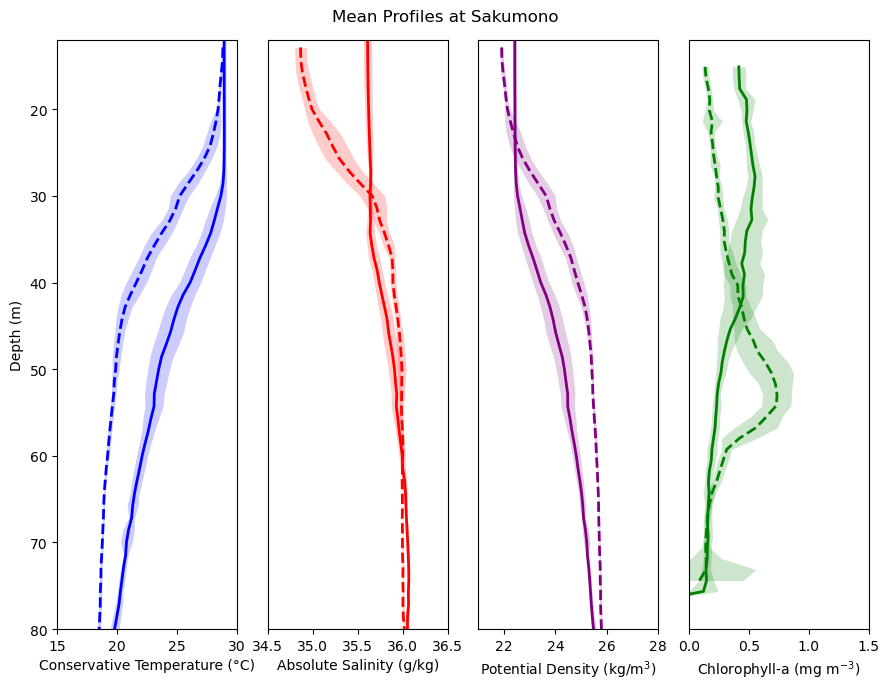

In [31]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(9, 7))

cruises = ['January', 'April']
ls = ['--', '-']

for cruise, ls in zip(cruises, ls):
    plot_mean_profiles(ax1, ax2, ax3, ax4, cruise, linestyle=ls, label=cruise)

# Axis labels/limits
for ax in [ax1, ax2, ax3]:
    ax.set_ylim(12, max_depth)
    ax.invert_yaxis()
    # ax.legend()

ax1.set_ylabel('Depth (m)') # 'Pressure (dbar)'
ax1.set_xlabel('Conservative Temperature (°C)')
ax1.set_xlim(15, 30)

ax2.set_xlabel('Absolute Salinity (g/kg)')
ax2.set_yticks([])
ax2.set_xlim(34.5, 36.5)

ax3.set_xlabel('Potential Density (kg/m$^3$)')
ax3.set_yticks([])
ax3.set_xlim(21, 28)

ax4.set_xlabel('Chlorophyll-a (mg m$^{-3}$)')
ax4.set_yticks([])
ax4.set_xlim(0, 1.5)

fig.suptitle(f"Mean Profiles at Sakumono")
plt.tight_layout()
plt.show()


In [ ]:
filename = f"2025_Jan_Apr_sakumono_avg_profiles.png"
fig.savefig(os.path.join(os.getcwd(),'figures', filename))

### (6) plot profiles of for any variables at specified location

In [32]:
variable_metadata = {
    "CT": {
        "dataset": "ctd",
        "label": r"Temperature ($\degree$C)",
        "units": "°C",
        "xlim": (15, 30),
        "color": "blue"
    },
    "SA": {
        "dataset": "ctd",
        "label": "Salinity (g/kg)",
        "units": "g/kg",
        "xlim": (34.5, 36.5),
        "color": "red"
    },
    "rho": {
        "dataset": "ctd",
        "label": r"Density (kg/m$^3$)",
        "units": "kg/m³",
        "xlim": (21, 28),
        "color": "purple"
    },
    "O2": {
        "dataset": "oxy",
        "label": "Oxygen (mmol/m$^3$)",
        "units": "µmol/kg",
        "xlim": (100, 250),
        "color": "orange"
    },
    "chl_cal": {
        "dataset": "fls",
        "label": "Chlorophyll (µg/L)",
        "units": "mg/m³",
        "xlim": (0, 2),
        "color": "green"
    },
    "bb470_cal": {
        "dataset": "fls",
        "label": "Backscatter (1/m)",
        "units": "1/m",
        "xlim": (0, 0.01),
        "color": "brown"
    }
}

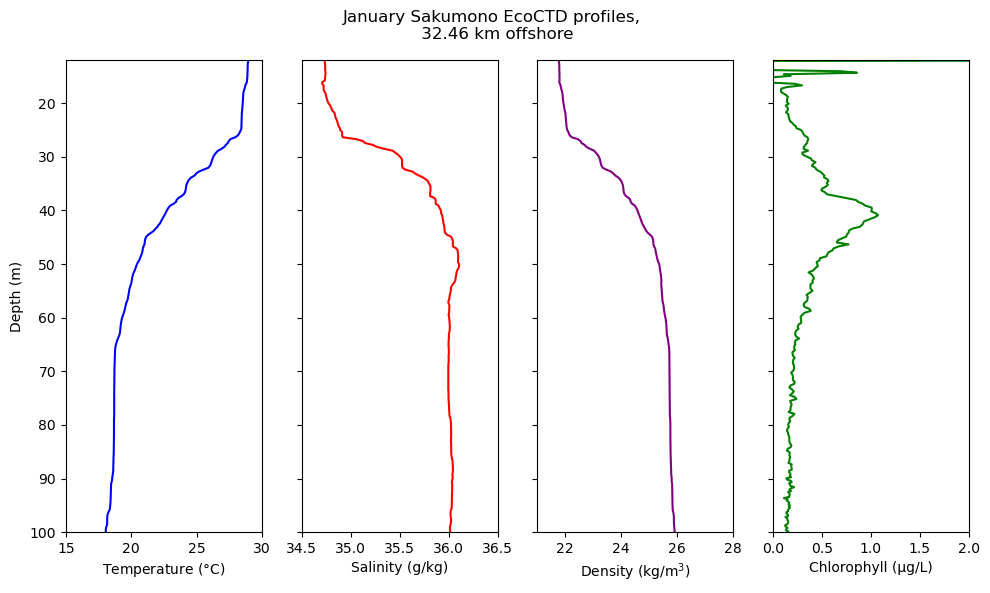

In [33]:
variables_to_plot = ["CT", "SA", "rho", "chl_cal"] # ["CT", "chl_cal", "O2"]

# Define working directory and cruise
cruise = 'January' # 'January', 'April' or 'August'
wkdir = f"{os.environ['WINPATH']}/OneDrive - Massachusetts Institute of Technology/mit-whoi/gulf_of_guinea/coessing_2025/EcoCTD_data/{cruise}/"
distance = np.load(f"GIS_data/{cruise}_distance.npy")

# set profile index
index = 40
max_depth = 100

# Initialize datasets dictionary
datasets = {}

# load datasets for each data type
for data_type in set(meta["dataset"] for meta in variable_metadata.values()):
    files = glob.glob(f"{wkdir}*{data_type}.nc")
    datasets[data_type] = [xr.open_dataset(f, decode_timedelta=True) for f in files]

if cruise == 'January':
    # reverse the order of datasets for January cruise
    for data_type in datasets:
        datasets[data_type] = datasets[data_type][::-1]

# determine number of variables
num_vars = len(variables_to_plot)

# create subplots
fig, axes = plt.subplots(1, num_vars, figsize=(2.5 * num_vars, 6))

# ensure axes is iterable
if num_vars == 1:
    axes = [axes]
    plural = ""
else:
    plural = "s"

fig.suptitle(f"{cruise} Sakumono EcoCTD profile{plural}, \n {round(distance[index], 2)} km offshore")
# fig.suptitle(f"{cruise} Sakumono EcoCTD profile{plural}, \n at profile number {index+1}")

# initialize depth variable
p = None

# plot each variable
for i, var in enumerate(variables_to_plot):
    meta = variable_metadata[var]
    data_type = meta["dataset"]
    ds = datasets[data_type][index]
    ax = axes[i]

    # retrieve/compute variable data
    if var == "rho":
        if p is None:
            p = ds["P"].values
            p = interpolate_nans(p, np.arange(len(p)))
        ct = ds["CT"].values
        sa = ds["SA"].values
        ct = interpolate_nans(ct, np.arange(len(ct)))
        sa = interpolate_nans(sa, np.arange(len(sa)))
        data = gsw.density.sigma0(sa, ct)
    else:
        data = ds[var].values
        if p is None:
            p = ds["P"].values
            p = interpolate_nans(p, np.arange(len(p)))
        data = interpolate_nans(data, np.arange(len(data)))
        if var == "O2":
            data = data*1000

    # plot data
    ax.plot(data, p, color=meta["color"], linewidth=1.5)
    ax.set_xlabel(meta["label"])
    ax.set_xlim(meta["xlim"])

    # set y-axis label for the first subplot
    if i == 0:
        ax.set_ylabel("Depth (m)")
    else:
        ax.set_yticklabels([])

    ax.set_ylim(12, max_depth)
    ax.invert_yaxis()


plt.tight_layout()
plt.show()

